In [859]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import sys
from array import array
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
# load pickle module
import pickle


from collections import defaultdict
# Insert the path of modules folder 
# sys.path.insert(0, 'C:/Users/Jason/thesis_project')
sys.path.append("../")

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *

In [2]:
X = genX([1994,2014], drop_0 = True)

Xbin = xBins(X, 'amd')

dropping all zero rows


### Looking at users from a specific bin 600-1200

In [106]:
list_len = []
list_ids = []

for ids in Xbin['2500-4000']:
    list_ids.append(ids)
    list_len.append(len(X.loc[ids,:]))

# Find the household that logged the most data
ix = list_len.index(max(list_len))

# Store the households ID
house_id = list_ids[ix]

# Create a dataframe with all of that households data
A = X.loc[house_id,:]
H = A.copy()

In [309]:
Xbin['400-600'][12]

48

In [318]:
df = X.loc[48].describe()

In [320]:
df.drop(['count','std','min','25%','50%','75%','max'], axis = 0, inplace=True)

In [ ]:
# Original find_peaks 1
# def find_peaksMA(X):
    
#     df = X.copy()
#     arrayX  = X.to_numpy().copy()
#     arrayY = X.to_numpy().copy()

#     listYM  = list(map(lambda x : x[3:11],arrayY))
#     listYA  = list(map(lambda x : x[17:],arrayY))

#     arrayYM = np.array(listYM)
#     arrayYA = np.array(listYA)
#     print(arrayYM)
#     # arrayYM.sort()
#     # arrayYA.sort()

#     dict_M = defaultdict(list)
#     dict_A = defaultdict(list)

#     df.reset_index(inplace = True)

#     for i in range(0,len(arrayX)):
#         indices_M = np.where(arrayYM[i] == np.amax(arrayYM[i]))
#         indices_A = np.where(arrayYA[i] == np.amax(arrayYA[i]))

#         dict_M[i].append(indices_M[0][0]) 
#         dict_A[i].append(indices_A[0][0])

#     ToP_M_df = pd.DataFrame.from_dict(dict_M)
#     ToP_A_df = pd.DataFrame.from_dict(dict_A)

#     top_M_dict = ToP_M_df.T + 3
#     top_A_dict = ToP_A_df.T + 17

#     dict_M.clear() 
#     dict_A.clear()


#     X1 = df.merge(top_M_dict, left_index = True, right_index = True).merge(top_A_dict,left_index = True, right_index = True)

#     return X1

In [482]:
# Original find_peaks 2
# def find_peaksMA(X):

#     df = X.copy()

#     arrayY = X.to_numpy().copy()

#     listYM  = list(map(lambda x : x[0:12],arrayY))
#     listYA  = list(map(lambda x : x[12:],arrayY))

#     arrayYM = np.array(listYM)
#     arrayYA = np.array(listYA)

#     arrayYM1 = np.array(listYM)
#     arrayYA1 = np.array(listYA)
#     # df.reset_index(inplace = True)
#     # df.drop(['mean'], axis = 1, inplace=True)

#     indices_M = np.where(arrayYM[0] == np.amax(arrayYM[0]))
#     indices_A = np.where(arrayYA[0] == np.amax(arrayYA[0]))
#     # print('indices_M = {}'.format(indices_M))
#     # print(range_min3(df, indices_M[0]))
#     while range_min3(arrayYM1[0], indices_M[0]) == False:
#     # if range_min3(df, indices_A[0] + 17) == False:
#         # Find the second largest peak
#         arrayYM[0][np.where(arrayYM[0] == np.amax(arrayYM[0]))] = 0
#         indices_M = np.where(arrayYM[0] == np.amax(arrayYM[0]))
#         # print(indices_M)
#         # print(arrayYM[0])
#         # print(range_min3(df, indices_A[0] + 17))

#     while range_min3(arrayYA1[0], indices_A[0]) == False:
#         # Find the second largest peak
#         arrayYA[0][np.where(arrayYA[0] == np.amax(arrayYA[0]))] = 0
#         indices_A = np.where(arrayYA[0] == np.amax(arrayYA[0]))


#     df['0_x'] = indices_M[0] 
#     df['0_y'] = indices_A[0] + 12 

#     return df

In [324]:
def find_peaksMA(X):

    df = X.copy()

    arrayY = X.to_numpy().copy()

    listYM  = list(map(lambda x : x[0:12],arrayY))
    listYA  = list(map(lambda x : x[12:],arrayY))

    arrayYM = np.array(listYM)
    arrayYA = np.array(listYA)

    arrayYM1 = np.array(listYM)
    arrayYA1 = np.array(listYA)

    indices_M = np.where(arrayYM[0] == np.amax(arrayYM[0]))
    indices_A = np.where(arrayYA[0] == np.amax(arrayYA[0]))

    while range_min3(arrayYM1[0], indices_M[0][0]) == False:
        arrayYM[0][np.where(arrayYM[0] == np.amax(arrayYM[0]))] = 0
        indices_M = np.where(arrayYM[0] == np.amax(arrayYM[0]))
        # print("arrayYM = {}".format(arrayYM))
        all_zeros = not np.any(arrayYM[0])
        if all_zeros == True:
            return df, False
        # print("all_zeros = {}".format(all_zeros))
  
    while range_min3(arrayYA1[0], indices_A[0][0]) == False:
        # Find the second largest peak
        arrayYA[0][np.where(arrayYA[0] == np.amax(arrayYA[0]))] = 0
        indices_A = np.where(arrayYA[0] == np.amax(arrayYA[0]))
        all_zeros = not np.any(arrayYA[0])
        if all_zeros == True:
            return df, False

    df['0_x'] = indices_M[0] 
    df['0_y'] = indices_A[0] + 12 

    return df, True

In [57]:
def slope():
    X = describe_household(id = 3223)
    df = X.copy()

    arrayY = X.to_numpy().copy()

    listYM  = list(map(lambda x : x[0:12],arrayY))
    listYA  = list(map(lambda x : x[11:],arrayY))

    arrayYM = np.array(listYM)
    arrayYA = np.array(listYA)

    return arrayYM, arrayYA

In [330]:
Xf = describe_household(id = 223)

In [331]:
Xf

(             0         1         2         3         4         5         6  \
 mean  2.266179  1.945473  1.769422  1.696878  1.920948  5.295354  5.590045   
 
              7         8         9  ...        16        17        18  \
 mean  4.086549  8.113917  8.803123  ...  7.868215  9.754917  9.996215   
 
            19        20        21        22        23  0_x  0_y  
 mean  8.41888  8.051965  7.299274  4.743505  2.994988    9   18  
 
 [1 rows x 26 columns],
 True)

In [65]:
slope_M, slope_A = slope()
slope_M[0]

In [21]:
len(slope_M[0])

12

In [30]:
y = slope_M[0]

In [31]:
dy=[y[i+1]-y[i] for i in range(len(y)-1)]
dy

[-0.27870524366696614,
 -0.19892677553201654,
 0.02495710524053507,
 -0.22672213194637303,
 0.0513256811379077,
 0.8227418060104057,
 1.1934092860485688,
 0.8785336096348653,
 0.3529451284185612,
 0.7280784424486901,
 1.0717934777989235]

In [394]:
dpy=[dy[i+1]-dy[i] for i in range(len(dy)-1)]

#### Function that finds range

In [255]:
def range_min3(df, indices_A):
    # print("df = {}".format(df))
    dy = [df[i+1]-df[i] for i in range(len(df)-1)]

    if indices_A == 11 or indices_A == 0 or indices_A == 12:
        return False  
    else:
        if dy[indices_A - 1] > 0 and dy[indices_A] < 0:
            # print("dy[indices_A - 2] < 0 and dy[indices_A - 1] > 0 = {} and {}".format(dy[indices_A - 2],dy[indices_A - 1]))
            return True    
        else:
            # print("dy[indices_A - 2] < 0 and dy[indices_A - 1] > 0 = {} and {}".format(dy[indices_A - 2],dy[indices_A - 1]))
            return False


No handles with labels found to put in legend.


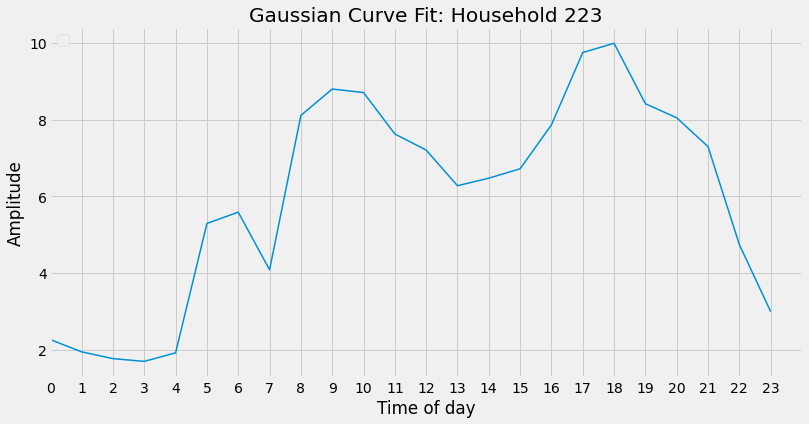

In [332]:
# build the plot
fig, ax = plt.subplots(figsize=(12,6))
plt.style.use('fivethirtyeight')  
i = 223
# Plot the households loadprofile
# fig = plt.plot(describe_household(id = i).iloc[0,0:24], linewidth = 1.5)#, linestyle = 'dashed')
fig = plt.plot(df.iloc[0,0:24], linewidth = 1.5)#, linestyle = 'dashed')
plt.title("Household "+str(i))


plt.legend(loc = "upper left")
# Set the labels and axis limits
ax.set_xlim([0,24])
ax.set_xlabel('Time of day')
ax.set_ylabel("Amplitude")
ax.set_title('Gaussian Curve Fit: Household ' + str(i))

# # Save the figure
# plt.savefig('GaussCurveFit' + str(houseID) + '.png', dpi=72, bbox_inches='tight')
plt.show()

# Detremine where the daily data increases and decreases after and before the peaks

### Find the average profile of a user

In [11]:
import random

list_len = []
list_ids = []

for ids in Xbin['600-1200']:
    list_ids.append(ids)
    list_len.append(len(X.loc[ids,:]))


# Gauss Fit Code

#### First load the consumption data

In [537]:
X = genX([1994,2014], drop_0 = True)

Xbin = xBins(X, 'amd')

dropping all zero rows


### Function to select a household

In [7]:
def selectRandomUser(Household):

    house_id = Household
    
    # Create a dataframe with all of that households data
    A = X.loc[house_id,:]
    H = A.copy()

    return H

#### Function to extract households average profile info

In [346]:
def describe_household(id):
       # Household ids
       # id = [12020322]#[483]#[2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]
       id = [id]

       for i in id:
              H = selectRandomUser(i)

              # H1 = find_peaksMA(H)
              H1_d = H.describe()

              H1_d = H1_d.drop(['count','std','min','max', '25%','50%','75%'])
              
              H1_d1, check = find_peaksMA(H1_d)

       # H1_d1.drop("mean", axis = 1, inplace=True)
              
       return H1_d1, check

#### Code to create Gaussian

In [9]:
#Define the Gaussian function
def gauss(x, H, A, mu, sigma):
    return H + A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

#### Code to plot the Gaussian fit

In [9]:
def plotGaussFit(y2):
    # Household ids
    # id = [2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

    x_all = np.arange(0, 24, 0.001) # entire range of x, both in and out of spec

    # build the plot
    fig, ax = plt.subplots(figsize=(12,6))
    plt.style.use('fivethirtyeight')  

    # Plot the households loadprofile
    fig = plt.plot(describe_household(id).iloc[0,0:24])
    plt.title("Household "+str(i))

    # Plot Gaussian fit
    ax.plot(x_all,y2)

    # Set the labels and axis limits
    ax.set_xlim([0,24])
    ax.set_xlabel('Time of day')
    ax.set_ylabel("Amplitude")
    ax.set_title('Gaussian Curve Fit')

    # # Save the figure
    # plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight')
    plt.show()

## START

### Select Household and Extract mean and amplitude of peaks

In [824]:
# id = [12020322]#[483]#[2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

#  1005558,  1006685,  1006691, 12029058, 12029066
houseID = 567

df, check = describe_household(id = houseID)

# Determine the y-offset i.e. minimum value in day
H_offset = df.iloc[0,:24].min()

# Determine the amplitude of gaussian
A1 = df[str(df['0_x'].values[0])].values[0] - H_offset # Adjust for offset
A2 = df[str(df['0_y'].values[0])].values[0] - H_offset

# Determine the mean of the gaussian
mu1 = df['0_x'].values[0]
mu2 = df['0_y'].values[0]

#### New and improved Function that calculates overall error of gauss fit

In [825]:
def Sigma1(increment = 0):
    # Conditional if statement to check that 
    p1 = 4 + increment

    i1 = 0

    Xpeak1 = df[str(df['0_x'].values[0])].values[0]

    for c in df:
        if int(c) != df['0_x'].values[0]:
            x1 = df[str(df['0_x'].values[0] - int(c))].values[0]
            temp1 = Xpeak1 - x1

            if temp1 >= 0.0:
                Xpeak1 = x1
            else:
                i1 = df['0_x'].values[0]-int(c) # i returns the index of the lower boundary of range
                break
        else:
            i1 = df['0_x'].values[0]-int(c) # i returns the index of the lower boundary of range
            break

    range1 = 2*(np.sqrt((df['0_x'].values[0] - i1)**2))
    
    sigma1 = range1/p1

    return sigma1, i1

In [826]:
# Code that finds the value one point above the range index
sigma1, i1 = Sigma1()

# Calculate error
actual = df.iloc[0,i1:df['0_x'].values[0]].to_list()
predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1)
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)

tolerance1 = RMSE - RMSE*0.95
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while RMSE > tolerance1:
    previous_error1 = RMSE

    sigma1, i1= Sigma1(increment = i)
    predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)   
    # conditional for gauss 1
    if RMSE > previous_error1:
        i = i + 0.1
        sigma1, i1 = Sigma1(increment = i)
        predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE) 
    else:
        i = i - 0.1
        sigma1, i1 = Sigma1(increment = i)
        predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE) 

    t = t + 1
    if t >= 10000:
        t = 0
        i = 0
        tolerance1 = tolerance1 + 0.1

RMSE1 = RMSE
print("RMSE1 = {}".format(RMSE1))
sigma1 = np.sqrt(sigma1**2)

RMSE1 = 0.4462964897480033


In [827]:
def Sigma2(increment = 0):
    # Conditional if statement to check that 
    p1 = 4 + increment

    i1 = 0

    Xpeak1 = df[str(df['0_x'].values[0])].values[0]# Get the value at the peak
    
    for c in df:
        x1 = df[str(df['0_x'].values[0]+int(c))].values[0]
        temp1 = Xpeak1 - x1
        # print("temp1 = Xpeak1 - x1 = {} - {} = {}".format(Xpeak1,x1,temp1))
        if temp1 >= 0:
            Xpeak1 = x1
        else:
            i1 = df['0_x'].values[0]+int(c) # i returns the index of the lower boundary of range
            break

    range1 = 2*(np.sqrt((df['0_x'].values[0] - i1)**2))

    sigma1 = range1/p1

    return sigma1, i1


In [828]:
sigma2, i2= Sigma2()

# Calculate error
actual = df.iloc[0,df['0_x'].values[0]:i2].to_list()
predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)

tolerance2 = RMSE - RMSE*0.95
print(tolerance2)
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while RMSE > tolerance2:

    # print("RMSE = {}".format(RMSE))
    # print("tolerance2 = {}".format(tolerance2))
    # print("actual = {}".format(actual))
    # print("predicted = {}".format(predicted))
    previous_error2 = RMSE
    sigma2, i2 = Sigma2(increment = i)
    predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)
    
    # Conditional for gauss2
    if RMSE > previous_error2:
        i = i + 0.1
        sigma2, i2 = Sigma2(increment = i)
        predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)
    else:
        i = i -0.1        
        sigma2, i2 = Sigma2(increment = i)
        predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)

    t = t + 1
    if t >= 1000:
        t = 0
        i = 0
        tolerance2 = tolerance2 + 0.1


RMSE2 = RMSE
print("RMSE2 = {}".format(RMSE2))
sigma2 = np.sqrt(sigma2**2)

0.11924648427494855
RMSE2 = 1.7054391266949889


In [829]:
def Sigma3(increment = 0):  
    # Conditional if statement to check that 
    p2 = 4 + increment

    # i1 = 0
    i2 = 0

    Xpeak2 = df[str(df['0_y'].values[0])].values[0]

    for c in df:
        x2 = df[str(df['0_y'].values[0]-int(c))].values[0]
        temp2 = Xpeak2 - x2
        
        if temp2 >= 0.0:
            Xpeak2 = x2
        else:
            i2 = df['0_y'].values[0]-int(c)+1 # i returns the index of the lower boundary of range
            break

    range2 = 2*(np.sqrt((df['0_y'].values[0] - i2)**2))

    sigma2 = range2/p2

    return sigma2, i2


In [830]:
# Code that finds the value one point above the range index
sigma3, i3 = Sigma3()

# Calculate error
actual = df.iloc[0,i3:df['0_y'].values[0]].to_list()
predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)

tolerance1 = RMSE - RMSE*0.95
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while RMSE > tolerance1:
    previous_error3 = RMSE
    # print(sigma3)
    # print("RMSE = {}".format(RMSE))

    sigma3, i3 = Sigma3(increment = i)
    predicted = gauss(np.arange(i3,df['0_y'].values[0],1), H_offset, A2, mu2, sigma3)
    # print('actual = {}'.format(actual))
    # print('predicted = {}'.format(predicted))
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    # conditional for gauss 1
    if RMSE > previous_error3:
        i = i + 0.1
        sigma3, i3 = Sigma3(increment = i)
        predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)
    else:
        i = i - 0.1
        sigma3, i3 = Sigma3(increment = i)
        predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)

    t = t + 1
    if t >= 10000:
        t = 0
        i = 0
        tolerance1 = tolerance1 + 0.1
   

RMSE3 = RMSE
print("RMSE3 = {}".format(RMSE))
sigma3 = np.sqrt(sigma3**2)


RMSE3 = 0.8465577953216388


In [831]:
def Sigma4(increment=0):
    # Conditional if statement to check that 
    p2 = 4 + increment

    i2 = 0

    Xpeak2 = df[str(df['0_y'].values[0])].values[0]# Get the value at the peak
    
    for c in df:
        try:
            x2 = df[str(df['0_y'].values[0]+int(c))].values[0] # Get the one after the peak
            temp2 = Xpeak2 - x2
            # print("temp2 = Xpeak2 - x2 = {} - {} = {}".format(Xpeak2,x2,temp2))
            
            if temp2 >= 0:
                Xpeak2 = x2
            else:
                i2 = df['0_y'].values[0]+int(c) # i returns the index of the lower boundary of range
                break
            
        except KeyError:
            i2 = df['0_y'].values[0]+int(c)
            break

    range2 = 2*(np.sqrt((df['0_y'].values[0] - i2)**2))
    
    sigma2 = range2/p2

    return sigma2, i2

In [832]:
sigma4, i4= Sigma4()

actual = df.iloc[0,df['0_y'].values[0]:i4].to_list()
predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)

tolerance2 = RMSE - RMSE*0.95
# print(tolerance2)
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while RMSE > tolerance2:
    previous_error4 = RMSE
    # print('sigma4 = {}'.format(sigma4))
    # print('RMSE = {}'.format(RMSE))
    sigma4, i4 = Sigma4(increment = i)
    predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)
    
    # Conditional for gauss2
    if RMSE > previous_error4:
        i = i + 0.1
        sigma4, i4 = Sigma4(increment = i)
        predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)

    else:
        i = i - 0.1        
        sigma4, i4 = Sigma4(increment = i)
        predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)

    t = t + 1
    if t >= 10000:
        t = 0
        i = 0
        tolerance2 = tolerance2 + 0.1
print(tolerance2)
RMSE4 = RMSE
sigma4 = np.sqrt(sigma4**2)


0.5583510458580723


#### Plot Gaussian Fit

In [833]:
# sigma1, sigma3, i1, i3= initialSigma1()
# sigma2, sigma4, i2, i4 = initialSigma2()
x_all = np.arange(0, 24, 0.1) # entire range of x, both in and out of spec
y1 = gauss(x_all, H_offset,A1,mu1,sigma1)
y2 = gauss(x_all, H_offset,A1,mu1,sigma2)
y3 = gauss(x_all, H_offset,A2,mu2,sigma3)
y4 = gauss(x_all, H_offset,A2,mu2,sigma4)

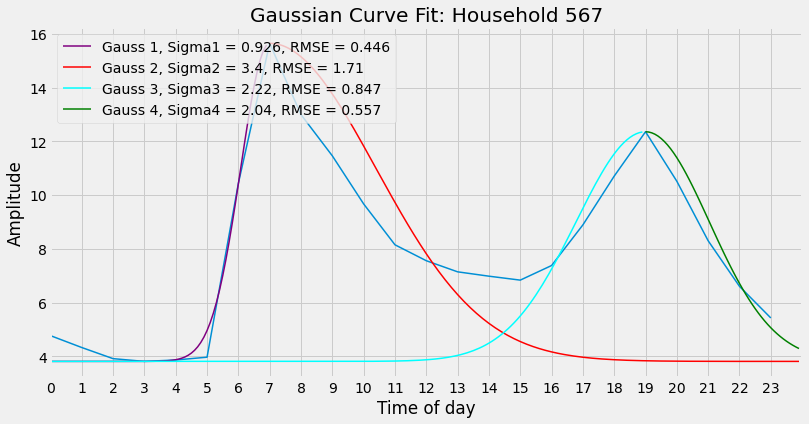

In [834]:
# build the plot
fig, ax = plt.subplots(figsize=(12,6))
plt.style.use('fivethirtyeight')  

# Plot the households loadprofile
fig = plt.plot(df.iloc[0,0:24], linewidth = 1.5)#, linestyle = 'dashed')
plt.title("Household "+str(i))

# Plot Gauss Fit

# ax.plot(x_all[:],y1[:],linewidth = 0.5, linestyle = 'dotted',color = 'purple')
ax.plot(x_all[:10*df['0_x'].values[0]],y1[:10*df['0_x'].values[0]],linewidth = 1.5, color = 'purple',label = "Gauss 1, Sigma1 = " + str('{0:.3g}'.format(sigma1))+ ", RMSE = " + str('{0:.3g}'.format(RMSE1)))
# ax.plot(x_all[:],y2[:],linewidth = 0.5, linestyle = 'dotted',color = 'red')
ax.plot(x_all[10*df['0_x'].values[0]:],y2[10*df['0_x'].values[0]:],linewidth = 1.5,color = 'red', label = "Gauss 2, Sigma2 = " + str('{0:.3g}'.format(sigma2))+ ", RMSE = " + str('{0:.3g}'.format(RMSE2)))
# ax.plot(x_all[:],y3[:],linewidth = 0.5, linestyle = 'dotted',color = 'cyan')
ax.plot(x_all[:10*df['0_y'].values[0]],y3[:10*df['0_y'].values[0]],linewidth = 1.5, color = 'cyan',label = "Gauss 3, Sigma3 = " + str('{0:.3g}'.format(sigma3))+ ", RMSE = " + str('{0:.3g}'.format(RMSE3)))
# ax.plot(x_all[:],y4[:],linewidth = 0.5, linestyle = 'dotted',color = 'green')
ax.plot(x_all[10*df['0_y'].values[0]:],y4[10*df['0_y'].values[0]:],linewidth = 1.5, color = 'green',label = "Gauss 4, Sigma4 = " + str('{0:.3g}'.format(sigma4))+ ", RMSE = " + str('{0:.3g}'.format(RMSE4)))

plt.legend(loc = "upper left")
# Set the labels and axis limits
ax.set_xlim([0,24])
ax.set_xlabel('Time of day')
ax.set_ylabel("Amplitude")
ax.set_title('Gaussian Curve Fit: Household ' + str(houseID))

# # Save the figure
# plt.savefig('GaussCurveFit' + str(houseID) + '.png', dpi=72, bbox_inches='tight')
plt.show()

## Calculate the RMSE of the entire profile

In [835]:
x_1 = np.arange(0, mu1, 1)
x_2 = np.arange(mu1, i2, 1)
x_3 = np.arange(i3, mu2,1)
x_4 = np.arange(mu2, 24,1)

x_vals = np.hstack((x_1,x_2,x_3,x_4))
x_vals_1 = np.unique(x_vals)


#### Create synthetic profile

In [836]:
def straight_line(m,x,b):
    return m*x+b

In [837]:
y1 = gauss(x_1, H_offset,A1,mu1,sigma1)
y2 = gauss(x_2, H_offset,A1,mu1,sigma2)
y3 = gauss(x_3, H_offset,A2,mu2,sigma3)
y4 = gauss(x_4, H_offset,A2,mu2,sigma4)

if len(x_vals_1) == 24:
    print("Entire array is captured")
    if x_2[-1] == x_3[0]:
        print('repeating value')
        x_3 = x_3[1:] # Remove the first value of the x-array
        y3 = gauss(x_3, H_offset,A2,mu2,sigma3) # Re-calculate the y-values for gauss 3
        synth = np.hstack((y1,y2,y3,y4)) # Generate the synthetic values
    else:
        synth = np.hstack((y1,y2,y3,y4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

else:
    print("Missing hours need to be saved")
    x_5 = np.arange(i2,i3,1)
    x_vals_1 = np.hstack((x_1,x_2,x_5,x_3,x_4))
    x_vals_1 = np.unique(x_vals_1)

    # Synthesize the mid range behaviour
    m = (gauss(x_3[0], H_offset,A2,mu2,sigma3) - gauss(x_2[-1], H_offset,A1,mu1,sigma2))/(x_3[0]-x_2[-1]) # Calculate slope
    b = gauss(x_3[0], H_offset,A2,mu2,sigma3) - m*x_3[0] # Calculate b constant for straight line equation
    y_mid = straight_line(m,x_5,b)

    synth = np.hstack((y1,y2,y_mid,y3,y4))

Entire array is captured
repeating value


### Calculate the RMSE of the actual vs synthetic profile

In [838]:
actual = df.iloc[0,0:24]
predicted = synth
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)

### Plot the synth and actual profile

Text(0.5, 1.0, 'Synthetic Profile: Household 567')

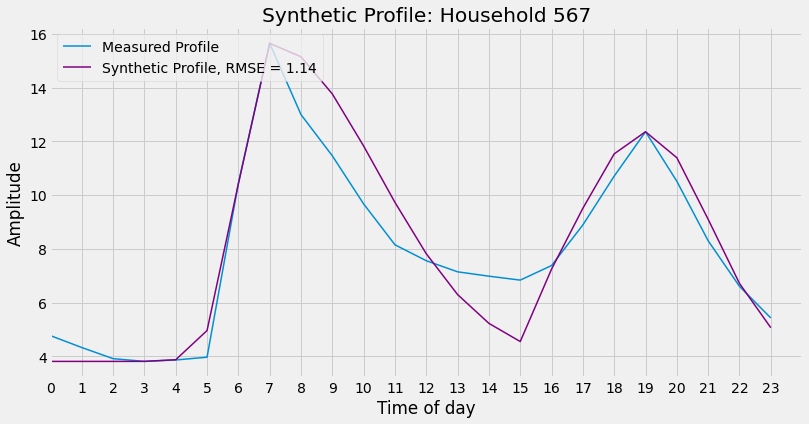

In [839]:
# build the plot
fig, ax = plt.subplots(figsize=(12,6))
plt.style.use('fivethirtyeight')  

# Plot the households loadprofile
fig = plt.plot(df.iloc[0,0:24], linewidth = 1.5, label = "Measured Profile")#, linestyle = 'dashed')
plt.title("Household "+str(i))
x_all = np.arange(0,24,1)
# Plot Gauss Fit
ax.plot(x_all,synth,linewidth = 1.5, color = 'purple',label = "Synthetic Profile, RMSE = " + str('{0:.3g}'.format(RMSE)))

plt.legend(loc = "upper left")
# Set the labels and axis limits
ax.set_xlim([0,24])
ax.set_xlabel('Time of day')
ax.set_ylabel("Amplitude")
ax.set_title('Synthetic Profile: Household ' + str(houseID))

# # Save the figure
plt.savefig('Synthetic Profile' + str(houseID) + '.png', dpi=72, bbox_inches='tight')
plt.show()

#  Write code to calculate the RMSE of all households and plot a histogram of the RMSE

In [909]:
for id in Xbin:
    print("ids = {}".format(id))

ids = 0-1
ids = 1-50
ids = 50-150
ids = 150-400
ids = 400-600
ids = 600-1200
ids = 1200-2500
ids = 2500-4000


In [353]:
# Create dataframe to store RMSE
list_ids = []
for id in Xbin['1200-2500']:
    list_ids.append(id)

ids_df = pd.DataFrame(index = list_ids, columns = ['RMSE'])
counter = 0
for id in tqdm(Xbin['1200-2500']):
    counter = counter + 1
    houseID = id
    df, check = describe_household(id = houseID)
    # Check whether the household has any morning/afternoon peaks
    if check == False:
        continue
    # Determine the y-offset i.e. minimum value in day
    H_offset = df.iloc[0,:24].min()

    # Determine the amplitude of gaussian
    A1 = df[str(df['0_x'].values[0])].values[0] - H_offset # Adjust for offset
    A2 = df[str(df['0_y'].values[0])].values[0] - H_offset

    # Determine the mean of the gaussian
    mu1 = df['0_x'].values[0]
    mu2 = df['0_y'].values[0]
    # **********************************************************************************************************************************************
    # Fit the first gaussian
    sigma1, i1 = Sigma1()

    # Calculate error
    actual = df.iloc[0,i1:df['0_x'].values[0]].to_list()
    predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance1 = RMSE - RMSE*0.95
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance1:
        previous_error1 = RMSE

        sigma1, i1= Sigma1(increment = i)
        predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)   
        # conditional for gauss 1
        if RMSE > previous_error1:
            i = i + 0.1
            sigma1, i1 = Sigma1(increment = i)
            predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE) 
        else:
            i = i - 0.1
            sigma1, i1 = Sigma1(increment = i)
            predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE) 

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance1 = tolerance1 + 0.1

    RMSE1 = RMSE
    # print("RMSE1 = {}".format(RMSE1))
    sigma1 = np.sqrt(sigma1**2)
    # **********************************************************************************************************************************************
    # Fit the secnd gaussian
    sigma2, i2= Sigma2()

    # Calculate error
    actual = df.iloc[0,df['0_x'].values[0]:i2].to_list()
    predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance2 = RMSE - RMSE*0.95
    # print(tolerance2)
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance2:

        # print("RMSE = {}".format(RMSE))
        # print("tolerance2 = {}".format(tolerance2))
        # print("actual = {}".format(actual))
        # print("predicted = {}".format(predicted))
        previous_error2 = RMSE
        sigma2, i2 = Sigma2(increment = i)
        predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)
        
        # Conditional for gauss2
        if RMSE > previous_error2:
            i = i + 0.1
            sigma2, i2 = Sigma2(increment = i)
            predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)
        else:
            i = i -0.1        
            sigma2, i2 = Sigma2(increment = i)
            predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        t = t + 1
        if t >= 1000:
            t = 0
            i = 0
            tolerance2 = tolerance2 + 0.1


    RMSE2 = RMSE
    # print("RMSE2 = {}".format(RMSE2))
    sigma2 = np.sqrt(sigma2**2)
    # **********************************************************************************************************************************************
    # Fit the third gaussian
    # Code that finds the value one point above the range index
    sigma3, i3 = Sigma3()

    # Calculate error
    actual = df.iloc[0,i3:df['0_y'].values[0]].to_list()
    predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance1 = RMSE - RMSE*0.95
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance1:
        previous_error3 = RMSE
        # print(sigma3)
        # print("RMSE = {}".format(RMSE))

        sigma3, i3 = Sigma3(increment = i)
        predicted = gauss(np.arange(i3,df['0_y'].values[0],1), H_offset, A2, mu2, sigma3)
        # print('actual = {}'.format(actual))
        # print('predicted = {}'.format(predicted))
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)

        # conditional for gauss 1
        if RMSE > previous_error3:
            i = i + 0.1
            sigma3, i3 = Sigma3(increment = i)
            predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)
        else:
            i = i - 0.1
            sigma3, i3 = Sigma3(increment = i)
            predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance1 = tolerance1 + 0.1
    

    RMSE3 = RMSE
    # print("RMSE3 = {}".format(RMSE))
    sigma3 = np.sqrt(sigma3**2)
    # **********************************************************************************************************************************************
    # Fit the 4th gaussian
    sigma4, i4= Sigma4()

    actual = df.iloc[0,df['0_y'].values[0]:i4].to_list()
    predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance2 = RMSE - RMSE*0.95
    # print(tolerance2)
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance2:
        previous_error4 = RMSE
        # print('sigma4 = {}'.format(sigma4))
        # print('RMSE = {}'.format(RMSE))
        sigma4, i4 = Sigma4(increment = i)
        predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)
        
        # Conditional for gauss2
        if RMSE > previous_error4:
            i = i + 0.1
            sigma4, i4 = Sigma4(increment = i)
            predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        else:
            i = i - 0.1        
            sigma4, i4 = Sigma4(increment = i)
            predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance2 = tolerance2 + 0.1
    # print(tolerance2)
    RMSE4 = RMSE
    sigma4 = np.sqrt(sigma4**2)
    # **********************************************************************************************************************************************
    # Determine the complete synthetic profile
    x_1 = np.arange(0, mu1, 1)
    x_2 = np.arange(mu1, i2, 1)
    x_3 = np.arange(i3, mu2,1)
    x_4 = np.arange(mu2, 24,1)

    x_vals = np.hstack((x_1,x_2,x_3,x_4))
    x_vals_1 = np.unique(x_vals)

    y1 = gauss(x_1, H_offset,A1,mu1,sigma1)
    y2 = gauss(x_2, H_offset,A1,mu1,sigma2)
    y3 = gauss(x_3, H_offset,A2,mu2,sigma3)
    y4 = gauss(x_4, H_offset,A2,mu2,sigma4)

    if len(x_vals_1) == 24:
        # print("Entire array is captured")
        if x_2[-1] == x_3[0]:
            # print('repeating value')
            x_3 = x_3[1:] # Remove the first value of the x-array
            y3 = gauss(x_3, H_offset,A2,mu2,sigma3) # Re-calculate the y-values for gauss 3
            synth = np.hstack((y1,y2,y3,y4)) # Generate the synthetic values
        else:
            synth = np.hstack((y1,y2,y3,y4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

    else:
        # print("Missing hours need to be saved")
        x_5 = np.arange(i2,i3,1)
        x_vals_1 = np.hstack((x_1,x_2,x_5,x_3,x_4))
        x_vals_1 = np.unique(x_vals_1)

        # Synthesize the mid range behaviour
        m = (gauss(x_3[0], H_offset,A2,mu2,sigma3) - gauss(x_2[-1], H_offset,A1,mu1,sigma2))/(x_3[0]-x_2[-1]) # Calculate slope
        b = gauss(x_3[0], H_offset,A2,mu2,sigma3) - m*x_3[0] # Calculate b constant for straight line equation
        y_mid = straight_line(m,x_5,b)

        synth = np.hstack((y1,y2,y_mid,y3,y4))
    # **********************************************************************************************************************************************
    # Calculate the synthetic profiles RMSE
    actual = df.iloc[0,0:24]
    predicted = synth
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)
    # **********************************************************************************************************************************************
    # Store the RMSE error
    ids_df.loc[id] = RMSE
    # **********************************************************************************************************************************************
    # if counter%50 == 0:
    #     # Save plot of fit
    #     fig, ax = plt.subplots(figsize=(12,6))
    #     plt.style.use('fivethirtyeight')  

    #     # Plot the households loadprofile
    #     fig = plt.plot(describe_household(id = houseID).iloc[0,0:24], linewidth = 1.5, label = "Measured Profile")#, linestyle = 'dashed')
    #     plt.title("Household "+str(i))
    #     x_all = np.arange(0,24,1)
    #     # Plot Gauss Fit
    #     ax.plot(x_all,synth,linewidth = 1.5, color = 'purple',label = "Synthetic Profile, RMSE = " + str('{0:.3g}'.format(RMSE)))

    #     plt.legend(loc = "upper left")
    #     # Set the labels and axis limits
    #     ax.set_xlim([0,24])
    #     ax.set_xlabel('Time of day')
    #     ax.set_ylabel("Amplitude")
    #     ax.set_title('Synthetic Profile: Household ' + str(houseID))

    #     # # Save the figure
    #     plt.savefig('Synthetic Profile' + str(houseID) + '.png', dpi=72, bbox_inches='tight')
    # **********************************************************************************************************************************************
    # **********************************************************************************************************************************************
    # **********************************************************************************************************************************************


<ipython-input-353-e90e98bfc952>:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/319 [00:00<?, ?it/s]

In [354]:
ids_df.to_csv('RMSE_1200_2500.csv', header=False, index=False)

# Plot Histogram of the RMSE's

In [390]:
def rmse_Histogram(AMC):
    # Creating the dataset
    rmse_DF = pd.read_csv('RMSE_' + AMC +'.csv', header = None)
    rmse_array = rmse_DF.values.T
    rmse_array = rmse_array[~np.isnan(rmse_array)] # Remove all NaN values from array
    n_bins = 20

    # Create histogram 
    fig, ax = plt.subplots(figsize = (10,7))
    ax.hist(rmse_array, bins = n_bins)
    # ax.legend(loc = "upper left")


    # Set the labels and axis limits
    ax.set_xlabel('RMSE')
    ax.set_ylabel("Count")
    ax.set_title('Histogram of RMSE: AMC = ' + AMC)

    # Show plot
    plt.show()

    # Save Fig
    fig.savefig('RMSE_Histogram_' + AMC + '.png', dpi=72, bbox_inches='tight')

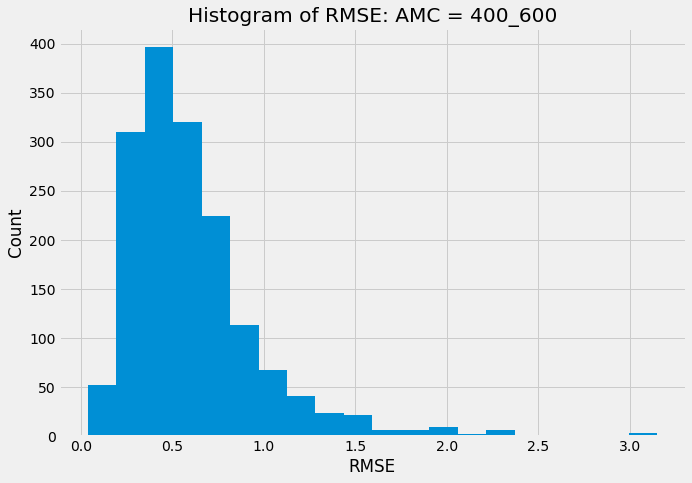

In [393]:
rmse_Histogram(AMC = '400_600')

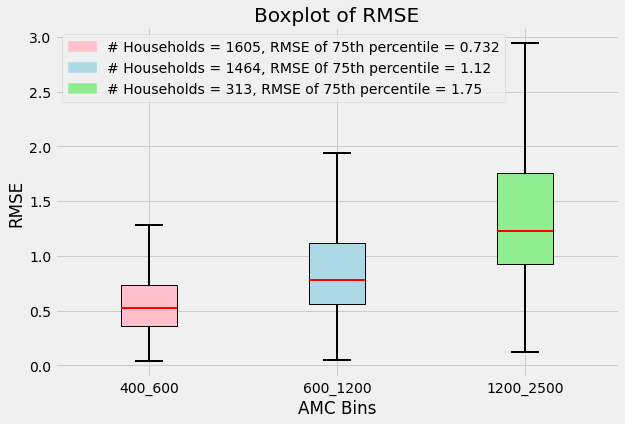

In [635]:

import matplotlib.patches as mpatches
amc_strings = ['400_600', '600_1200', '1200_2500']

# rmse_DF = pd.read_csv('RMSE_' + amc_strings[0] +'.csv', header = None)

for vals in amc_strings:
    temp_DF = pd.read_csv('RMSE_' + vals +'.csv', header = None)
    rmse_array = temp_DF.values.T
    rmse_array = rmse_array[~np.isnan(rmse_array)] # Remove all NaN values from array

    if vals == amc_strings[0]:
        rmse_400_600 = rmse_array
    elif vals == amc_strings[1]:
        rmse_600_1200 = rmse_array
    elif vals == amc_strings[2]:
        rmse_1200_2500 = rmse_array

# combine three different datasets into a list
data_to_plot = [rmse_400_600, rmse_600_1200, rmse_1200_2500]

# Create boxplot
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, showfliers=False, patch_artist=True, labels = ['400_600', '600_1200', '1200_2500'])

## change outline color, fill color and linewidth of the boxes
# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='black', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='red', linewidth=2)

# Creating legend with color box
pop_a = mpatches.Patch(color=colors[0], label='# Households = ' + str(len(rmse_400_600)) + ', ' + 'RMSE of 75th percentile = ' + str('{0:.3g}'.format(np.percentile(rmse_400_600,75))))
pop_b = mpatches.Patch(color=colors[1], label='# Households = ' + str(len(rmse_600_1200)) + ', ' + 'RMSE 0f 75th percentile = ' + str('{0:.3g}'.format(np.percentile(rmse_600_1200,75))))
pop_c = mpatches.Patch(color=colors[2], label='# Households = ' + str(len(rmse_1200_2500)) + ', ' + 'RMSE of 75th percentile = ' + str('{0:.3g}'.format(np.percentile(rmse_1200_2500,75))))

ax.legend(handles = [pop_a, pop_b, pop_c])

ax.set_title('Boxplot of RMSE')
ax.set_xlabel('AMC Bins')
ax.set_ylabel('RMSE')


# Save the figure
fig.savefig('RMSE_Boxplot.png', bbox_inches='tight')


# Plot the 75th percentile RMSE profile of the different bins

In [510]:
print("400_600 75th percentile  = {}".format(np.percentile(rmse_400_600,75)))
print("600_1200 75th percentile  = {}".format(np.percentile(rmse_600_1200,75)))
print("1200_2500 75th percentile  = {}".format(np.percentile(rmse_1200_2500,75)))

400_600 75th percentile  = 0.731703301738174
600_1200 75th percentile  = 1.116508013939519
1200_2500 75th percentile  = 1.75449031154408


### Function that generates Synthetic Profile

In [786]:
def syntheticProfile(houseID):
    df, check = describe_household(id = houseID)

    # Determine the y-offset i.e. minimum value in day
    H_offset = df.iloc[0,:24].min()

    # Determine the amplitude of gaussian
    A1 = df[str(df['0_x'].values[0])].values[0] - H_offset # Adjust for offset
    A2 = df[str(df['0_y'].values[0])].values[0] - H_offset

    # Determine the mean of the gaussian
    mu1 = df['0_x'].values[0]
    mu2 = df['0_y'].values[0]
    # **********************************************************************************************************************************************
    # Fit the first gaussian
    sigma1, i1 = Sigma1()

    # Calculate error
    actual = df.iloc[0,i1:df['0_x'].values[0]].to_list()
    predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance1 = RMSE - RMSE*0.95
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance1:
        previous_error1 = RMSE

        sigma1, i1= Sigma1(increment = i)
        predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)   
        # conditional for gauss 1
        if RMSE > previous_error1:
            i = i + 0.1
            sigma1, i1 = Sigma1(increment = i)
            predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE) 
        else:
            i = i - 0.1
            sigma1, i1 = Sigma1(increment = i)
            predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE) 

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance1 = tolerance1 + 0.1

    RMSE1 = RMSE
    # print("RMSE1 = {}".format(RMSE1))
    sigma1 = np.sqrt(sigma1**2)
    # **********************************************************************************************************************************************
    # Fit the secnd gaussian
    sigma2, i2= Sigma2()

    # Calculate error
    actual = df.iloc[0,df['0_x'].values[0]:i2].to_list()
    predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance2 = RMSE - RMSE*0.95
    # print(tolerance2)
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance2:
        previous_error2 = RMSE
        sigma2, i2 = Sigma2(increment = i)
        predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)
        
        # Conditional for gauss2
        if RMSE > previous_error2:
            i = i + 0.1
            sigma2, i2 = Sigma2(increment = i)
            predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)
        else:
            i = i -0.1        
            sigma2, i2 = Sigma2(increment = i)
            predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        t = t + 1
        if t >= 1000:
            t = 0
            i = 0
            tolerance2 = tolerance2 + 0.1


    RMSE2 = RMSE
    # print("RMSE2 = {}".format(RMSE2))
    sigma2 = np.sqrt(sigma2**2)
    # **********************************************************************************************************************************************
    # Fit the third gaussian
    # Code that finds the value one point above the range index
    sigma3, i3 = Sigma3()

    # Calculate error
    actual = df.iloc[0,i3:df['0_y'].values[0]].to_list()
    predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance1 = RMSE - RMSE*0.95
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance1:
        previous_error3 = RMSE
        # print(sigma3)
        # print("RMSE = {}".format(RMSE))

        sigma3, i3 = Sigma3(increment = i)
        predicted = gauss(np.arange(i3,df['0_y'].values[0],1), H_offset, A2, mu2, sigma3)
        # print('actual = {}'.format(actual))
        # print('predicted = {}'.format(predicted))
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)

        # conditional for gauss 1
        if RMSE > previous_error3:
            i = i + 0.1
            sigma3, i3 = Sigma3(increment = i)
            predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)
        else:
            i = i - 0.1
            sigma3, i3 = Sigma3(increment = i)
            predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance1 = tolerance1 + 0.1
    

    RMSE3 = RMSE
    # print("RMSE3 = {}".format(RMSE))
    sigma3 = np.sqrt(sigma3**2)
    # **********************************************************************************************************************************************
    # Fit the 4th gaussian
    sigma4, i4= Sigma4()

    actual = df.iloc[0,df['0_y'].values[0]:i4].to_list()
    predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
    print(predicted)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance2 = RMSE - RMSE*0.95
    # print(tolerance2)
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance2:
        previous_error4 = RMSE
        # print('sigma4 = {}'.format(sigma4))
        # print('RMSE = {}'.format(RMSE))
        sigma4, i4 = Sigma4(increment = i)
        predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)
        
        # Conditional for gauss2
        if RMSE > previous_error4:
            i = i + 0.1
            sigma4, i4 = Sigma4(increment = i)
            predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        else:
            i = i - 0.1        
            sigma4, i4 = Sigma4(increment = i)
            predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance2 = tolerance2 + 0.1
    # print(tolerance2)
    RMSE4 = RMSE
    sigma4 = np.sqrt(sigma4**2)
    # **********************************************************************************************************************************************
    # Determine the complete synthetic profile
    x_1 = np.arange(0, mu1, 1)
    x_2 = np.arange(mu1, i2, 1)
    x_3 = np.arange(i3, mu2,1)
    x_4 = np.arange(mu2, 24,1)

    x_vals = np.hstack((x_1,x_2,x_3,x_4))
    x_vals_1 = np.unique(x_vals)

    y1 = gauss(x_1, H_offset,A1,mu1,sigma1)
    y2 = gauss(x_2, H_offset,A1,mu1,sigma2)
    y3 = gauss(x_3, H_offset,A2,mu2,sigma3)
    y4 = gauss(x_4, H_offset,A2,mu2,sigma4)

    if len(x_vals_1) == 24:
        # print("Entire array is captured")
        if x_2[-1] == x_3[0]:
            x_3 = x_3[1:] # Remove the first value of the x-array
            y3 = gauss(x_3, H_offset,A2,mu2,sigma3) # Re-calculate the y-values for gauss 3
            synth = np.hstack((y1,y2,y3,y4)) # Generate the synthetic values
        else:
            synth = np.hstack((y1,y2,y3,y4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

    else:
        # print("Missing hours need to be saved")
        x_5 = np.arange(i2,i3,1)
        x_vals_1 = np.hstack((x_1,x_2,x_5,x_3,x_4))
        x_vals_1 = np.unique(x_vals_1)

        # Synthesize the mid range behaviour
        m = (gauss(x_3[0], H_offset,A2,mu2,sigma3) - gauss(x_2[-1], H_offset,A1,mu1,sigma2))/(x_3[0]-x_2[-1]) # Calculate slope
        b = gauss(x_3[0], H_offset,A2,mu2,sigma3) - m*x_3[0] # Calculate b constant for straight line equation
        y_mid = straight_line(m,x_5,b)

        synth = np.hstack((y1,y2,y_mid,y3,y4))
    # **********************************************************************************************************************************************
    # Calculate the synthetic profiles RMSE
    actual = df.iloc[0,0:24]
    predicted = synth
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    return actual, predicted, RMSE


In [820]:
id

567

## Save the n-th percentile plot 

[12.36072003 11.70346058 10.01963549  7.97309128  6.18883846]


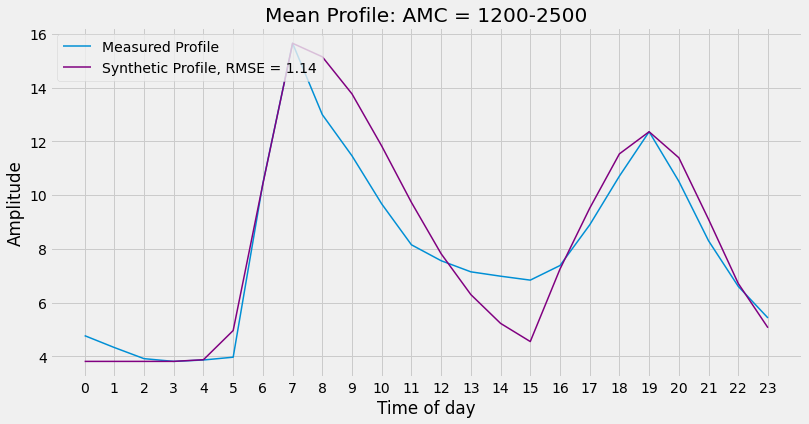

In [848]:
amc_string = '1200_2500'
amc_string2 = '1200-2500'
amc_string3 = rmse_1200_2500
percentile = 95
tolerance = 1.2

# Get a household that falls above the 75th percentile
DF = pd.read_csv('RMSE_' + amc_string + '.csv', header = None)
# DF1 = DF[DF[0] >= np.percentile(amc_string3,percentile)]
# DF2 = DF1[DF1[0] <= np.percentile(amc_string3,percentile) + 0.01]
DF1 = DF[DF[0] >= tolerance - 0.1]
DF2 = DF1[DF1[0] <= tolerance]
index = DF2.index[0]

# Get householdID from RMSE dataset
temp_DF = X.loc[Xbin[amc_string2]]
temp_DF.reset_index(inplace=True)
profilesIDs = temp_DF['ProfileID'].unique()

id = profilesIDs[index]

actual, predicted, RMSE = syntheticProfile(id)

# Create lineplot
x_all = np.arange(0,24,1)

fig, ax = plt.subplots(figsize=(12,6))
plt.style.use('fivethirtyeight')  

# Plot the households loadprofile
fig = plt.plot(actual, linewidth = 1.5,  label = "Measured Profile")#, linestyle = 'dashed')

# Plot Gauss Fit
ax.plot(x_all,predicted,linewidth = 1.5, color = 'purple',label = "Synthetic Profile, RMSE = " + str('{0:.3g}'.format(RMSE)))

plt.legend(loc = 'upper left')
# Set the labels and axis limits
ax.set_xlabel('Time of day')
ax.set_ylabel("Amplitude")
ax.set_title('Mean Profile: AMC = ' + amc_string2)# + vals)

plt.savefig(str(percentile) + 'th_percentile_' + str(amc_string) + '.png',dpi = 72, bbox_inches='tight')
# plt.savefig('Tolerance_' + str(tolerance) + '_' + str(amc_string) + '.png',dpi = 72, bbox_inches='tight')
plt.show()

# Sort Profile according to RMSE tolerance

In [864]:
amc_strings = ['400_600', '600_1200', '1200_2500']
amc_string2 = ['400-600','600-1200','1200-2500']
RMSE_dict = {'400_600':[],'600_1200':[],'1200_2500':[]}

for vals, vals2 in zip(amc_strings, amc_string2):
    # print("{},{}".format(vals,vals2))
    temp_DF = pd.read_csv('RMSE_' + vals +'.csv', header = None)
    temp_DF = temp_DF[temp_DF[0] <= 1.2]
    index = temp_DF.index
    # Get householdID from RMSE dataset
    temp_DF = X.loc[Xbin[vals2]]
    temp_DF.reset_index(inplace=True)
    profilesIDs = temp_DF['ProfileID'].unique()
    # print(index)
    # break
    ids = profilesIDs[index]

    RMSE_dict[vals] = ids


# Store the sorted households
# open file for writing
# f = open("sorted_households.txt","w")

# # write file
# f.write( str(RMSE_dict) )

# # close file
# f.close()

# create a binary pickle file 
f = open("sorted_households.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(RMSE_dict,f)

# close file
f.close()

# data = pd.read_pickle('sorted_households.pkl') # Read pickle file